In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

# Load files

In [3]:
trnImage = np.load('data/trnImage.npy')
trnLabel_fine = np.load('data/trnLabel_fine.npy')
trnLabel_coarse = np.load('data/trnLabel_coarse.npy')
tstImage = np.load('data/tstImage.npy')
tstLabel_fine = np.load('data/tstLabel_fine.npy')
tstLabel_coarse = np.load('data/tstLabel_coarse.npy')
trnImage = np.rollaxis(trnImage,axis=3)
tstImage = np.rollaxis(tstImage,axis=3)

In [4]:
print(f'shape of trnImage is: {trnImage.shape}')
print(f'shape of trnLabel_fine is: {trnLabel_fine.shape}')
print(f'shape of trnLabel_coarse is: {trnLabel_coarse.shape}')
print(f'shape of tstImage is: {tstImage.shape}')
print(f'shape of tstLabel_fine is: {tstLabel_fine.shape}')
print(f'shape of tstLabel_coarse is: {tstLabel_coarse.shape}')

shape of trnImage is: (50000, 32, 32, 3)
shape of trnLabel_fine is: (50000,)
shape of trnLabel_coarse is: (50000,)
shape of tstImage is: (10000, 32, 32, 3)
shape of tstLabel_fine is: (10000,)
shape of tstLabel_coarse is: (10000,)


## Extract hog features in different files

In [33]:
hog_arr = []
for image in tqdm(trnImage):
  # Extract features from a single image
  hog_feature = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], channel_axis=2)
  hog_arr.append(hog_feature)
np.save('hogFeature2.npy',hog_arr)

100%|██████████| 50000/50000 [08:21<00:00, 99.64it/s] 


In [52]:
hog_arr = []
for image in tqdm(tstImage):
  # Extract features from a single image
  hog_feature = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], channel_axis=2)
  hog_arr.append(hog_feature)
np.save('hogFeatures_tst.npy',hog_arr)

100%|██████████| 10000/10000 [01:41<00:00, 98.09it/s]


In [166]:
hog_arr = []
for image in tqdm(trnImage):
  # Extract features from a single image
  hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True,channel_axis=2)
  hog_arr.append(hog_feature)
np.save('hogFeaturesImage_trn.npy',hog_arr)

100%|██████████| 50000/50000 [39:36<00:00, 21.04it/s]


In [167]:
hog_arr = []
for image in tqdm(tstImage):
  # Extract features from a single image
  hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True,channel_axis=2)
  hog_arr.append(hog_feature)
np.save('hogFeaturesImage_tst.npy',hog_arr)

100%|██████████| 10000/10000 [07:48<00:00, 21.34it/s]


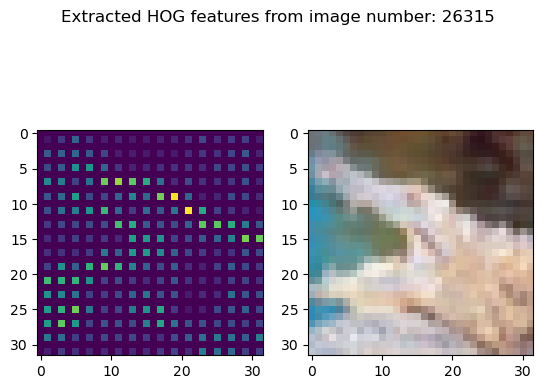

In [6]:
img = np.load('data/trnImage.npy')
image_index = np.random.randint(img.shape[3]) # random image
image = img[:, :, :,image_index]
# Extract features from a single random image
hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True, channel_axis=2)

plt.figure()
plt.subplot(121)
plt.imshow(hog_image)
plt.subplot(122)
plt.imshow(image)
plt.suptitle(f'Extracted HOG features from image number: {image_index}')
plt.show()

# Create Neural Network and save it

## Fine

In [5]:
checkpoint_filepath = 'savedModels/nn_fine.h5'

In [6]:
input_shape = trnImage.shape[1:]

model = keras.Sequential([
    keras.Input(input_shape),
    layers.Flatten(),
    layers.Dense(2086,activation="relu"),
    layers.Dense(1043,activation="relu"),
    layers.Dense(521,activation="relu"),
    layers.Dense(260,activation="relu"),
    layers.Dense(len(np.unique(trnLabel_fine)),activation=tf.nn.softmax),
])

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()
              )

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(trnImage,trnLabel_fine, epochs=25, validation_split=0.2, verbose=1,callbacks = [model_checkpoint_callback])

Epoch 1/25
1250/1250 [==============================] - 39s 31ms/step - loss: 4.2979 - sparse_categorical_accuracy: 0.0519 - val_loss: 4.0058 - val_sparse_categorical_accuracy: 0.0873
Epoch 2/25
1250/1250 [==============================] - 35s 28ms/step - loss: 3.8866 - sparse_categorical_accuracy: 0.1088 - val_loss: 3.8071 - val_sparse_categorical_accuracy: 0.1221
Epoch 3/25
1250/1250 [==============================] - 36s 28ms/step - loss: 3.6929 - sparse_categorical_accuracy: 0.1409 - val_loss: 3.6947 - val_sparse_categorical_accuracy: 0.1408
Epoch 4/25
1250/1250 [==============================] - 34s 27ms/step - loss: 3.5705 - sparse_categorical_accuracy: 0.1651 - val_loss: 3.5536 - val_sparse_categorical_accuracy: 0.1657
Epoch 5/25
1250/1250 [==============================] - 31s 25ms/step - loss: 3.4690 - sparse_categorical_accuracy: 0.1824 - val_loss: 3.5153 - val_sparse_categorical_accuracy: 0.1722
Epoch 6/25
1250/1250 [==============================] - 32s 25ms/step - loss: 3.

### evaluate model with the test dataset and print the best accuracy from the saved model

In [7]:
model = keras.models.load_model(checkpoint_filepath)

print(model.summary())

scores = model.evaluate(tstImage,tstLabel_fine, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 2086)              6410278   
                                                                 
 dense_1 (Dense)             (None, 1043)              2176741   
                                                                 
 dense_2 (Dense)             (None, 521)               543924    
                                                                 
 dense_3 (Dense)             (None, 260)               135720    
                                                                 
 dense_4 (Dense)             (None, 100)               26100     
                                                                 
Total params: 9,292,763
Trainable params: 9,292,763
Non-

### Print Accuracy and Loss curves and Confusion matrix

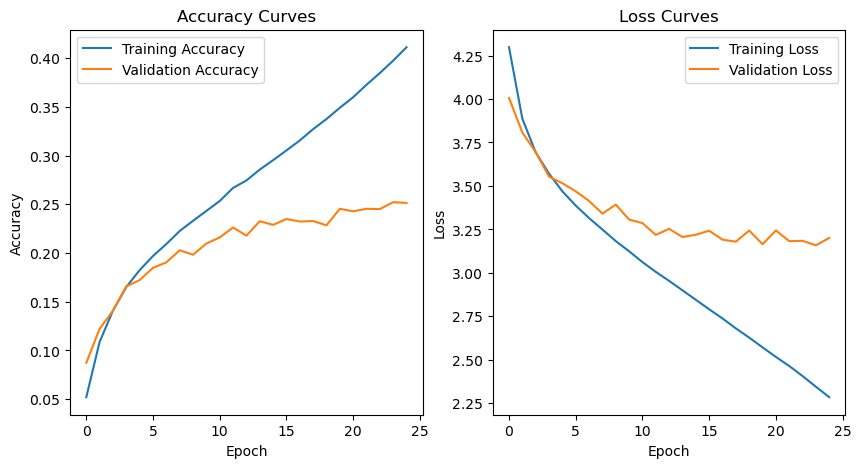

In [8]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.savefig("curves_NN_fine.jpg")
plt.show()

313/313 [==============================] - 3s 9ms/step


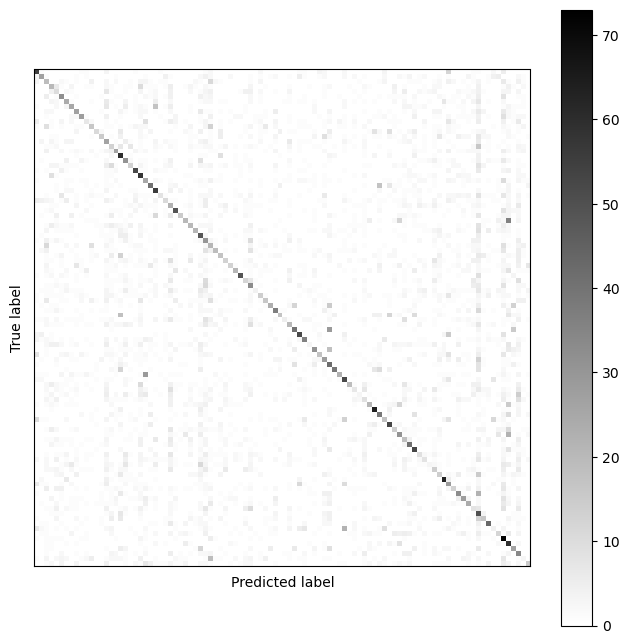

In [9]:
predictions = model.predict(tstImage)
predicted_classes = np.argmax(predictions, axis=1)


cm = confusion_matrix(tstLabel_fine,predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= np.arange(100))
fig, ax =  plt.subplots(figsize=(8,8))
disp.plot(ax = ax,include_values=False,cmap='binary')
ax.set_yticks([])
ax.set_xticks([])
plt.savefig("CM_fine_nn.jpg")

## Coarse

In [10]:
checkpoint_filepath = 'savedModels/nn_coarse.h5'

In [11]:
input_shape = trnImage.shape[1:]

model = keras.Sequential([
    keras.Input(input_shape),
    layers.Flatten(),
    layers.Dense(2086,activation="relu"),
    layers.Dense(1043,activation="relu"),
    layers.Dense(521,activation="relu"),
    layers.Dense(260,activation="relu"),
    layers.Dense(120,activation="relu"),
    layers.Dense(len(np.unique(trnLabel_coarse)),activation=tf.nn.softmax),
])

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()
              )

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(trnImage,trnLabel_coarse, epochs=25, validation_split=0.2, verbose=1,callbacks = [model_checkpoint_callback])

Epoch 1/25
1250/1250 [==============================] - 32s 25ms/step - loss: 2.6634 - sparse_categorical_accuracy: 0.1783 - val_loss: 2.5219 - val_sparse_categorical_accuracy: 0.2339
Epoch 2/25
1250/1250 [==============================] - 30s 24ms/step - loss: 2.4359 - sparse_categorical_accuracy: 0.2487 - val_loss: 2.3579 - val_sparse_categorical_accuracy: 0.2742
Epoch 3/25
1250/1250 [==============================] - 30s 24ms/step - loss: 2.3364 - sparse_categorical_accuracy: 0.2763 - val_loss: 2.3632 - val_sparse_categorical_accuracy: 0.2675
Epoch 4/25
1250/1250 [==============================] - 30s 24ms/step - loss: 2.2670 - sparse_categorical_accuracy: 0.3002 - val_loss: 2.2758 - val_sparse_categorical_accuracy: 0.2964
Epoch 5/25
1250/1250 [==============================] - 30s 24ms/step - loss: 2.2125 - sparse_categorical_accuracy: 0.3171 - val_loss: 2.2659 - val_sparse_categorical_accuracy: 0.3014
Epoch 6/25
1250/1250 [==============================] - 30s 24ms/step - loss: 2.

### evaluate model with the test dataset and print the best accuracy from the saved model

In [12]:
model = keras.models.load_model(checkpoint_filepath)

print(model.summary())

scores = model.evaluate(tstImage,tstLabel_coarse, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 2086)              6410278   
                                                                 
 dense_6 (Dense)             (None, 1043)              2176741   
                                                                 
 dense_7 (Dense)             (None, 521)               543924    
                                                                 
 dense_8 (Dense)             (None, 260)               135720    
                                                                 
 dense_9 (Dense)             (None, 120)               31320     
                                                                 
 dense_10 (Dense)            (None, 20)               

### Print Accuracy and Loss curves and Confusion matrix

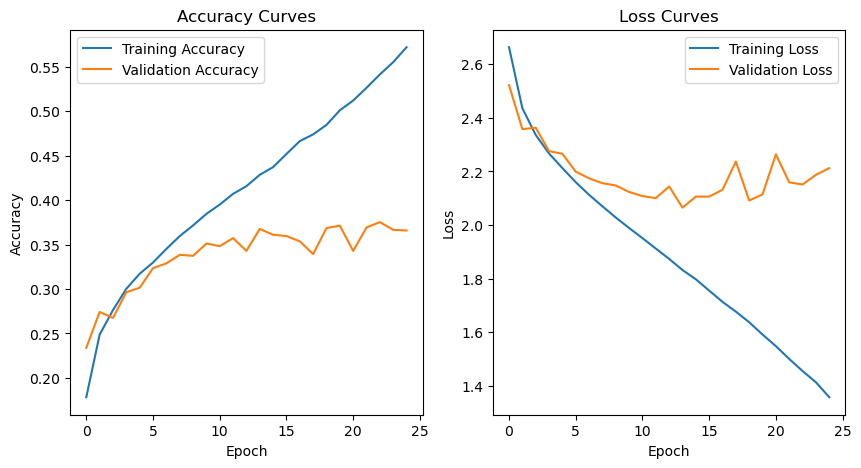

In [13]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.savefig("curves_NN_Coarse.jpg")
plt.show()

313/313 [==============================] - 3s 8ms/step


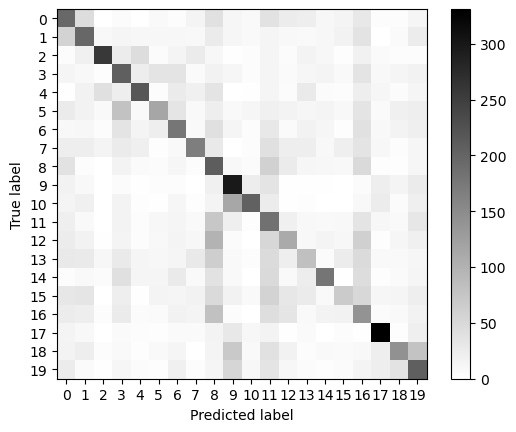

In [14]:
predictions = model.predict(tstImage)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(tstLabel_coarse,predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=False,cmap='binary')
plt.savefig("CM_coarse_nn.jpg")
plt.show()

# Create Convolutional Neural Network

## Fine

In [15]:
checkpoint_filepath = 'savedModels/cnn_fine.h5'

In [16]:
input_shape = trnImage.shape[1:]
modelCNN = keras.Sequential([
    layers.Conv2D(32,3,activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,3,activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512,activation="relu"),
    layers.Dense(len(np.unique(trnLabel_fine)),activation=tf.nn.softmax)
])

modelCNN.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()
              )

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

history = modelCNN.fit(trnImage,trnLabel_fine, epochs=30, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/30
1250/1250 [==============================] - 22s 17ms/step - loss: 4.5283 - sparse_categorical_accuracy: 0.0230 - val_loss: 4.3331 - val_sparse_categorical_accuracy: 0.0400
Epoch 2/30
1250/1250 [==============================] - 19s 16ms/step - loss: 4.1475 - sparse_categorical_accuracy: 0.0676 - val_loss: 4.0629 - val_sparse_categorical_accuracy: 0.0763
Epoch 3/30
1250/1250 [==============================] - 25s 20ms/step - loss: 3.9211 - sparse_categorical_accuracy: 0.1066 - val_loss: 3.8355 - val_sparse_categorical_accuracy: 0.1212
Epoch 4/30
1250/1250 [==============================] - 20s 16ms/step - loss: 3.7117 - sparse_categorical_accuracy: 0.1412 - val_loss: 3.7210 - val_sparse_categorical_accuracy: 0.1381
Epoch 5/30
1250/1250 [==============================] - 20s 16ms/step - loss: 3.5200 - sparse_categorical_accuracy: 0.1750 - val_loss: 3.4986 - val_sparse_categorical_accuracy: 0.1737
Epoch 6/30
1250/1250 [==============================] - 19s 16ms/step - loss: 3.

### evaluate model with the test dataset and print the best accuracy from the saved model

In [17]:
model = keras.models.load_model(checkpoint_filepath)

print(model.summary())

scores = model.evaluate(tstImage,tstLabel_fine, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

### Print Accuracy and Loss curves and Confusion matrix

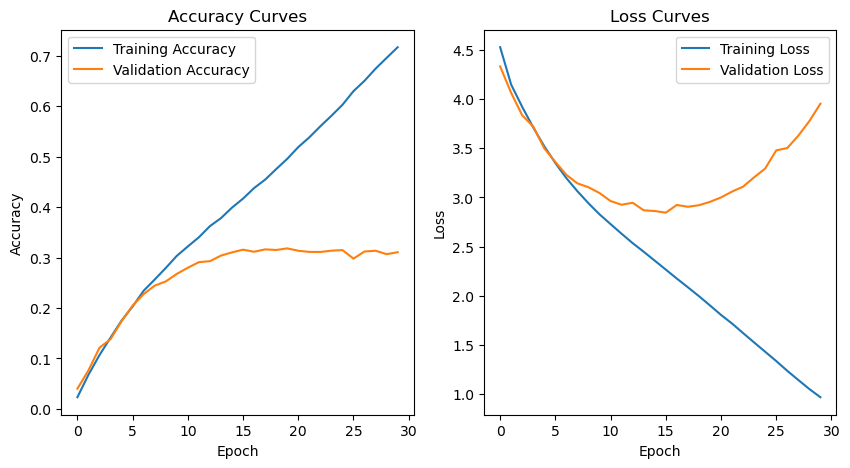

In [18]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.savefig("curves_CNN_finer.jpg")
plt.show()

313/313 [==============================] - 2s 6ms/step


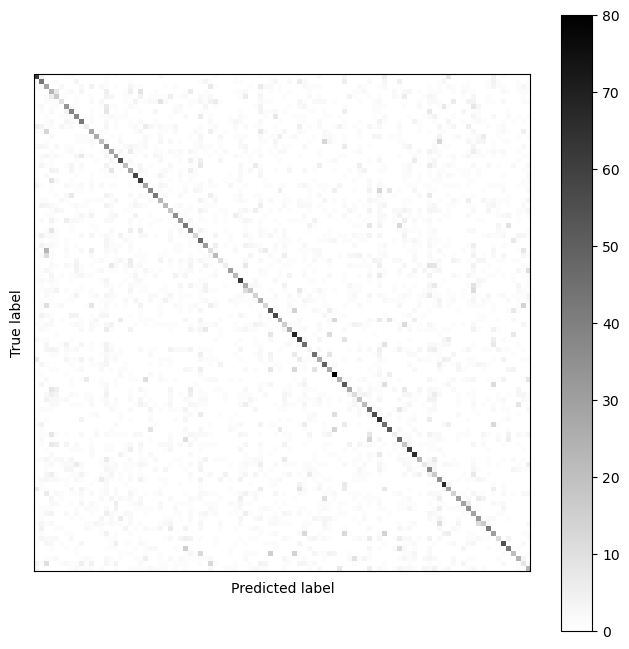

In [19]:
predictions = model.predict(tstImage)
predicted_classes = np.argmax(predictions, axis=1)


cm = confusion_matrix(tstLabel_fine,predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= np.arange(100))
fig, ax =  plt.subplots(figsize=(8,8))
disp.plot(ax = ax,include_values=False,cmap='binary')
ax.set_yticks([])
ax.set_xticks([])
plt.savefig("CM_fine_cnn.jpg")

## Coarse

In [20]:
checkpoint_filepath = 'savedModels/cnn_Coarse.h5'

In [21]:
input_shape = trnImage.shape[1:]
modelCNN = keras.Sequential([
    layers.Conv2D(32,3,activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,3,activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,3, activation='relu'),
    layers.Flatten(),
    layers.Dense(512,activation="relu"),
    layers.Dense(len(np.unique(trnLabel_coarse)),activation=tf.nn.softmax)
])

modelCNN.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()
              )

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

history = modelCNN.fit(trnImage,trnLabel_coarse, epochs=30, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/30
1250/1250 [==============================] - 22s 17ms/step - loss: 2.8293 - sparse_categorical_accuracy: 0.1240 - val_loss: 2.6621 - val_sparse_categorical_accuracy: 0.1741
Epoch 2/30
1250/1250 [==============================] - 20s 16ms/step - loss: 2.5829 - sparse_categorical_accuracy: 0.2007 - val_loss: 2.5125 - val_sparse_categorical_accuracy: 0.2294
Epoch 3/30
1250/1250 [==============================] - 20s 16ms/step - loss: 2.4474 - sparse_categorical_accuracy: 0.2421 - val_loss: 2.4032 - val_sparse_categorical_accuracy: 0.2597
Epoch 4/30
1250/1250 [==============================] - 20s 16ms/step - loss: 2.3364 - sparse_categorical_accuracy: 0.2796 - val_loss: 2.3464 - val_sparse_categorical_accuracy: 0.2734
Epoch 5/30
1250/1250 [==============================] - 19s 16ms/step - loss: 2.2371 - sparse_categorical_accuracy: 0.3100 - val_loss: 2.2401 - val_sparse_categorical_accuracy: 0.3044
Epoch 6/30
1250/1250 [==============================] - 20s 16ms/step - loss: 2.

### evaluate model with the test dataset and print the best accuracy from the saved model

In [22]:
model = keras.models.load_model(checkpoint_filepath)

print(model.summary())

scores = model.evaluate(tstImage,tstLabel_coarse, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 1024)             

### Print Accuracy and Loss curves and Confusion matrix

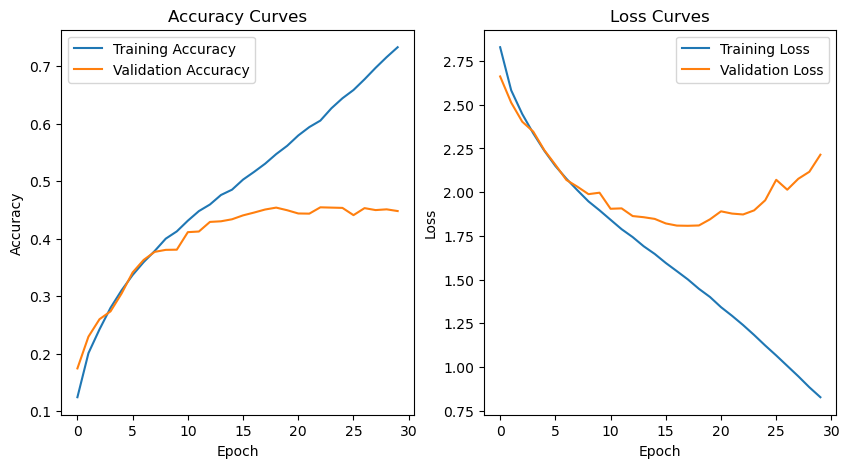

In [23]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.savefig("curves_CNN_coarse.jpg")
plt.show()

313/313 [==============================] - 2s 6ms/step


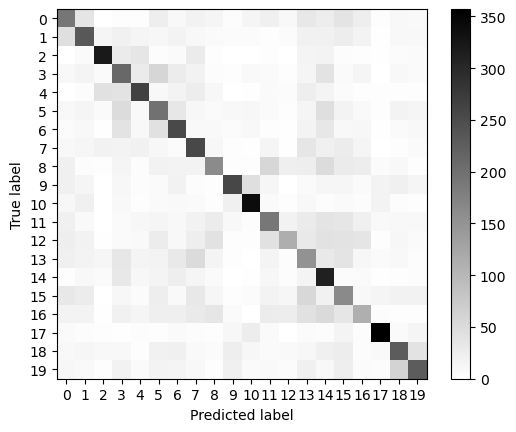

In [24]:
predictions = model.predict(tstImage)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(tstLabel_coarse,predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=False,cmap='binary')
plt.savefig("CM_coarse_cnn.jpg")
plt.show()